# Time Series

## Load data

In [1]:
import datetime as dt
from yahoo_fin.stock_info import get_data
import plotly.graph_objects as go

In [37]:
stock = 'BTC-USD'
resolution = '1d'
end_date = dt.datetime.now() - dt.timedelta(days=1)
start_date = end_date - dt.timedelta(days=365)

In [38]:
btc_df = get_data(stock, start_date, end_date, index_as_date=False, interval=resolution)

In [39]:
# btc_df.to_csv('btc-usd.csv')

## Plot data

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

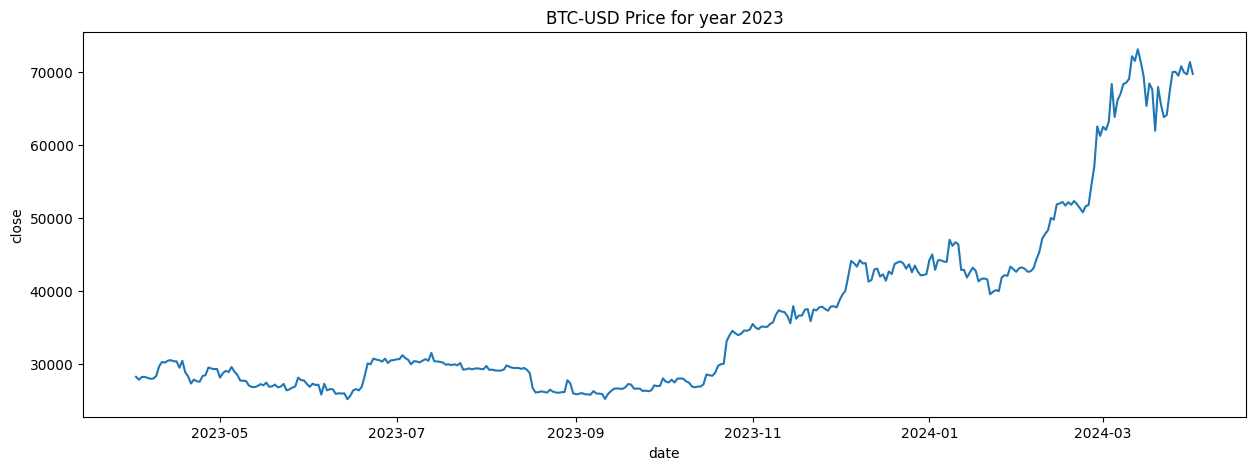

In [41]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=btc_df, x=btc_df.date, y=btc_df.close)
plt.title(f'{stock} Price for year 2023')
plt.show()

In [42]:
fig = go.Figure(data=[go.Candlestick(x = btc_df.date,
                                     open = btc_df.open, 
                                     high = btc_df.high,
                                     low = btc_df.low, 
                                     close = btc_df.close)
                     ])
fig.update_layout(title="Candlestick BTC-USD", yaxis_title="BTC-USD ($)", title_x=0.5)
fig.update_layout(xaxis_rangeslider_visible=False)
fig

## Autocorrelation function

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

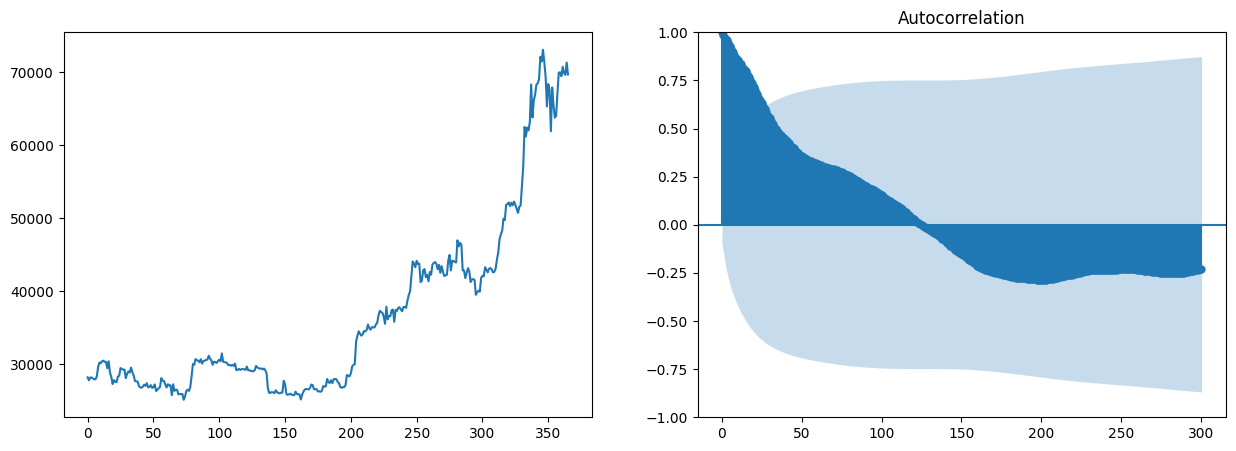

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(btc_df.close)
plot_acf(btc_df.close.dropna(), lags=300, ax=axes[1])

plt.show()

In [45]:
close = adfuller(btc_df.close)
print(f'p-value: {close[1]:.3f}')

p-value: 0.997


We have a high p-value which means we fail to reject the null hypothesis. This implies that the data is non-stationary.

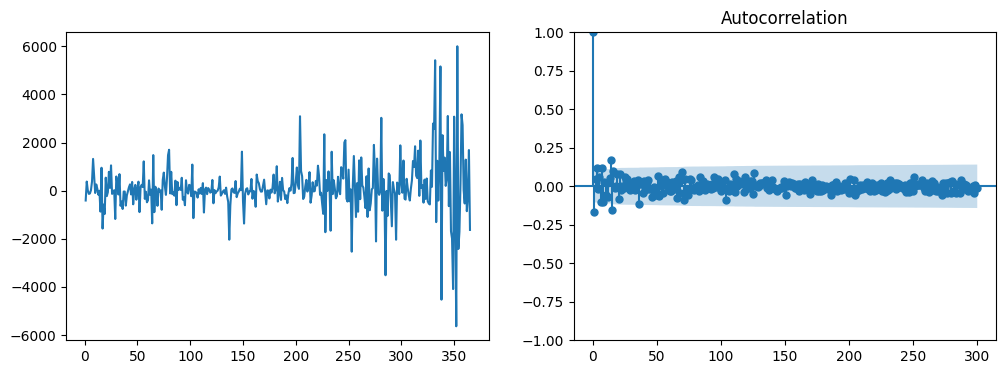

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(btc_df.close.diff())
plot_acf(btc_df.close.diff().dropna(), lags=300, ax=axes[1])

plt.show()

In [47]:
close = adfuller(btc_df.close.diff().dropna())
print(f'p-value: {close[1]:.3f}')

p-value: 0.000


We have a very low p-value which means we can reject the null hypothesis. This implies that that we can assume with a very high confidence that the data is stationary.

## ARIMA model

### Best orders

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import best_order_arima_aic, best_order_arima_bic, best_order_arima_hqic, forecast_accuracy

import warnings
warnings.filterwarnings("ignore")

nb_data = len(btc_df.close)
range_p = range(5)
range_d = range(1, 2)
range_q = range(5)

nb_day_predicted = [7, 14, 21, 28]

train_size = nb_data - max(nb_day_predicted)
train = pd.DataFrame(btc_df.close[:train_size])
dates_train = btc_df.date[:train_size]
best_order_aic = best_order_arima_aic(train, range_p, range_d, range_q)
best_order_bic = best_order_arima_bic(train, range_p, range_d, range_q)
best_order_hqic = best_order_arima_hqic(train, range_p, range_d, range_q)

print(f'Best order AIC: {best_order_aic}')
print(f'Best order BIC: {best_order_bic}')
print(f'Best order HQIC: {best_order_hqic}')

Best order AIC: (1, 1, 1)
Best order BIC: (0, 1, 0)
Best order HQIC: (1, 1, 1)


### Rolling forecast

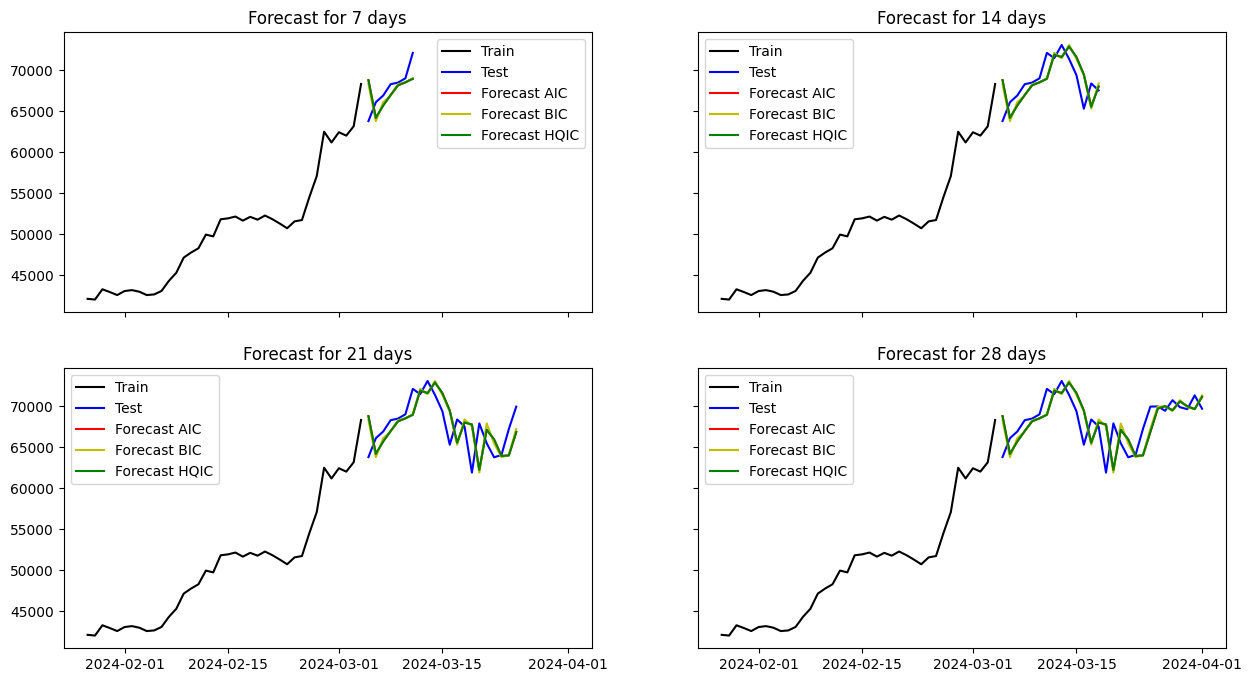

In [49]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)

results_rf = pd.DataFrame(columns=["", "MAPE", "MAE", "RMSE", "MSE", "R2"])

predictions = {"predictions_aic": {f"{n}d": [] for n in nb_day_predicted}, "predictions_bic": {f"{n}d": [] for n in nb_day_predicted}, "predictions_hqic": {f"{n}d": [] for n in nb_day_predicted}}

for i, n_test in enumerate(nb_day_predicted):
    rolling_train = train[:]
    test = btc_df.close[train_size:train_size + n_test]
    dates_test = btc_df.date[train_size:train_size + n_test]
    
    for value in test:
        arima_aic = ARIMA(rolling_train, order=best_order_aic).fit()
        arima_bic = ARIMA(rolling_train, order=best_order_bic).fit()
        arima_hqic = ARIMA(rolling_train, order=best_order_hqic).fit()
        prediction_aic = arima_aic.forecast().values[0]
        prediction_bic = arima_bic.forecast().values[0]
        prediction_hqic = arima_hqic.forecast().values[0]
        predictions["predictions_aic"][f"{n_test}d"].append(prediction_aic)
        predictions["predictions_bic"][f"{n_test}d"].append(prediction_bic)
        predictions["predictions_hqic"][f"{n_test}d"].append(prediction_hqic)
        rolling_train.loc[len(rolling_train)] = value
    
    results_rf.loc[len(results_rf)] = [f"{n_test} (aic)", *forecast_accuracy(test, predictions["predictions_aic"][f"{n_test}d"])]
    results_rf.loc[len(results_rf)] = [f"{n_test} (bic)", *forecast_accuracy(test, predictions["predictions_bic"][f"{n_test}d"])]
    results_rf.loc[len(results_rf)] = [f"{n_test} (hqic)", *forecast_accuracy(test, predictions["predictions_hqic"][f"{n_test}d"])]

    axes[i//2, i%2].plot(dates_train[300:], train[300:], label="Train", color='k')
    axes[i//2, i%2].plot(dates_test, test, label="Test", color='b')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_aic"][f"{n_test}d"], label="Forecast AIC", color='r')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_bic"][f"{n_test}d"], label="Forecast BIC", color='y')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_hqic"][f"{n_test}d"], label="Forecast HQIC", color='g')
    axes[i//2, i%2].set_title(f"Forecast for {n_test} days")
    axes[i//2, i%2].legend()
plt.show()

In [50]:
print(results_rf.to_string(index=False))

           MAPE  MAE    RMSE  MSE     R2
  7 (aic) 0.029 1916 6018137 2453 -0.039
  7 (bic) 0.027 1835 5476542 2340  0.054
 7 (hqic) 0.029 1916 6018137 2453 -0.039
 14 (aic) 0.028 1894 5520334 2349  0.173
 14 (bic) 0.028 1913 5358406 2314  0.198
14 (hqic) 0.028 1894 5520334 2349  0.173
 21 (aic) 0.034 2302 8163051 2857  0.042
 21 (bic) 0.035 2320 8055089 2838  0.055
21 (hqic) 0.034 2302 8163051 2857  0.042
 28 (aic) 0.029 1950 6389395 2527  0.157
 28 (bic) 0.029 1964 6335858 2517  0.164
28 (hqic) 0.029 1950 6389395 2527  0.157


The best results are obtained with aic metric. We can watch at the correlation and independency of the residuals.

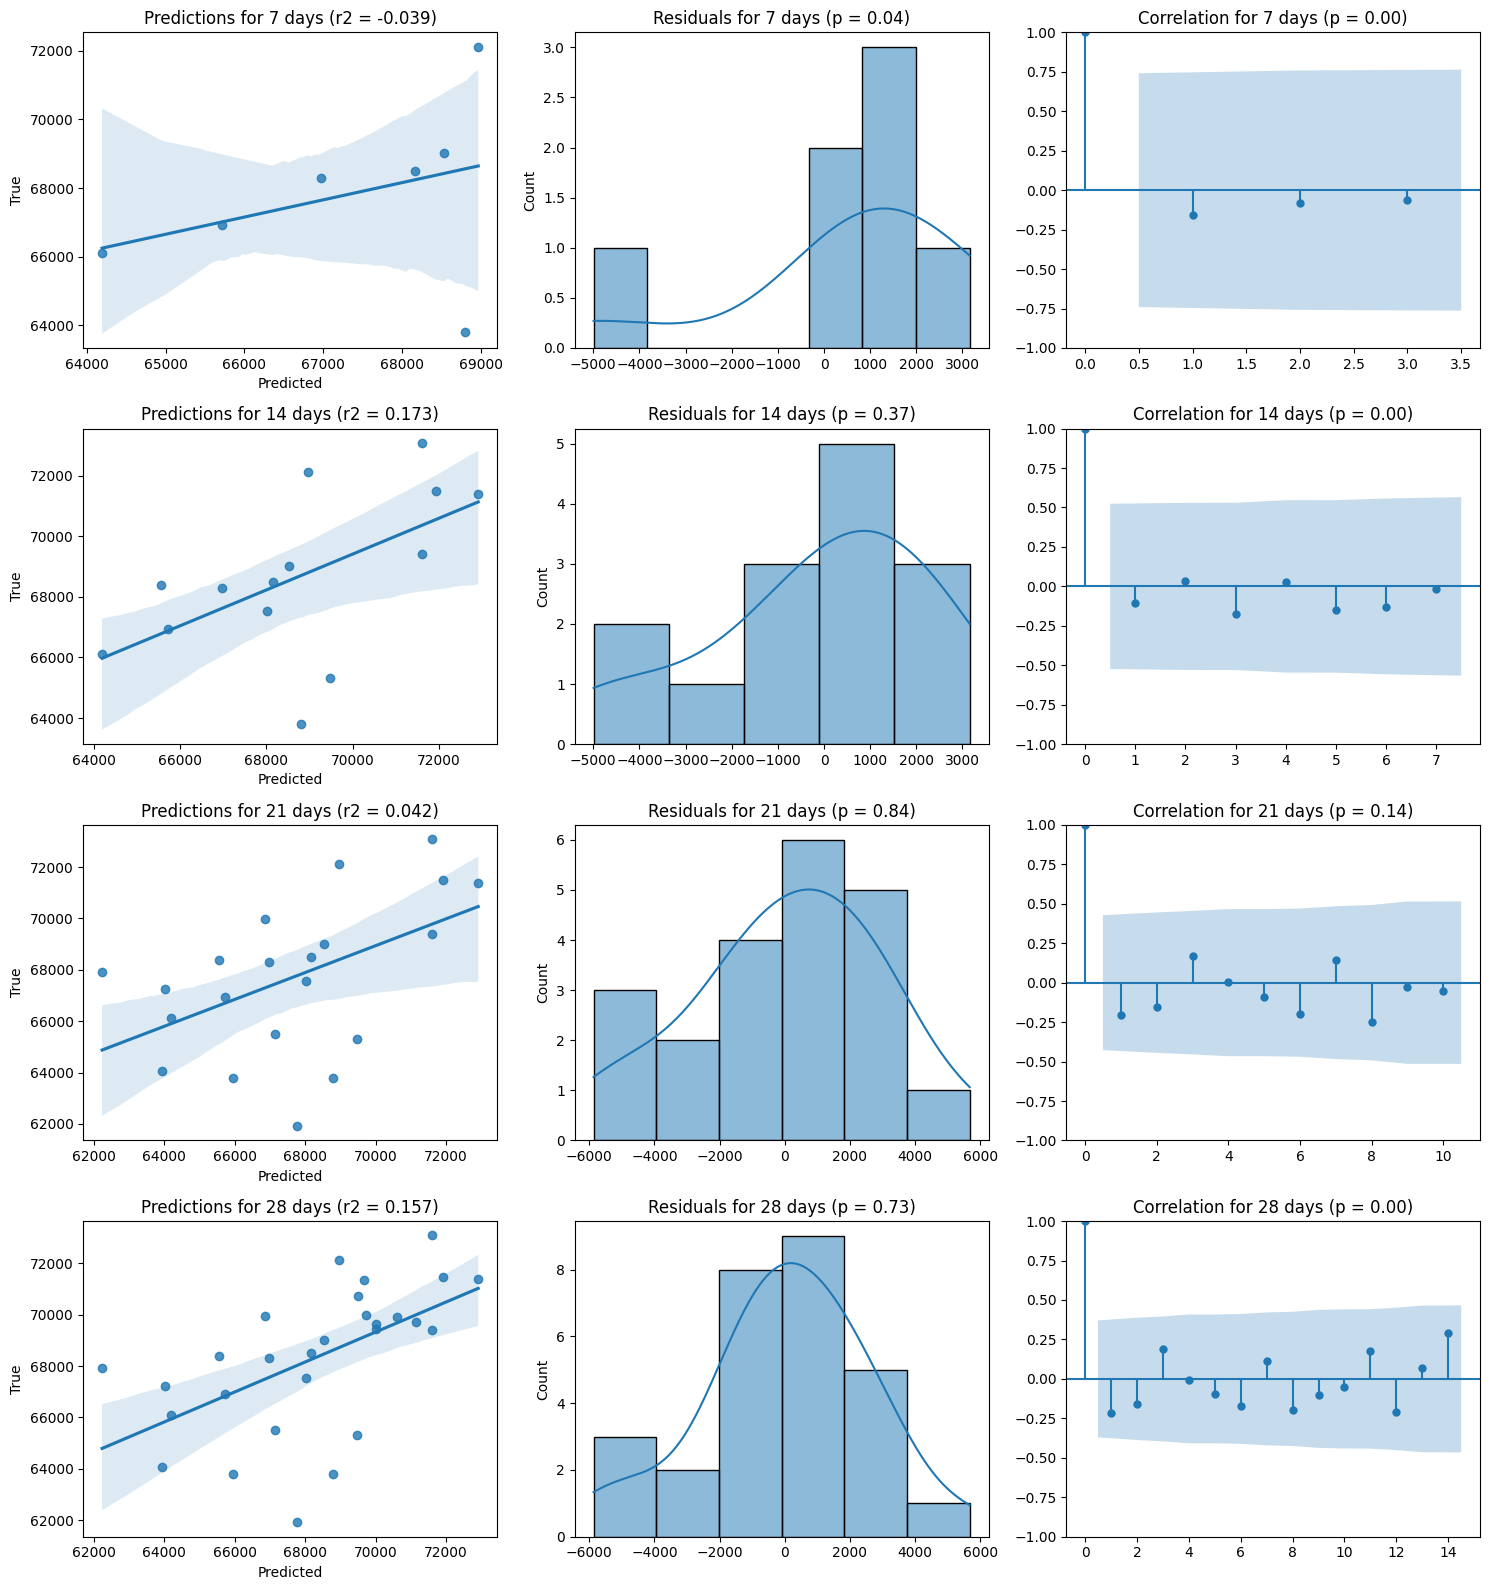

In [51]:
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

fig2, axes2 = plt.subplots(4, 3, figsize=(15, 16))
best_metric = "predictions_aic"

for i, n_test in enumerate(nb_day_predicted):
    test = btc_df.close[train_size:train_size + n_test]
    residuals_aic = pd.Series([test - prediction for test, prediction in zip(test, predictions[best_metric][f"{n_test}d"])])


    sns.regplot(x=predictions[best_metric][f"{n_test}d"], y=test, ax=axes2[i, 0])
    sns.histplot(residuals_aic, ax=axes2[i, 1], kde=True)
    plot_acf(residuals_aic, ax=axes2[i, 2])
    
    axes2[i, 0].set_xlabel("Predicted")
    axes2[i, 0].set_ylabel("True")
    r2 = forecast_accuracy(test, predictions[best_metric][f'{n_test}d'])[4]
    axes2[i, 0].set_title(f"Predictions for {n_test} days (r2 = {r2})")
    axes2[i, 1].set_title(f"Residuals for {n_test} days (p = {shapiro(residuals_aic)[1]:.2f})")
    axes2[i, 2].set_title(f"Correlation for {n_test} days (p = {adfuller(residuals_aic)[1]:.2f})")

plt.tight_layout()
plt.show()

We obtain low r2 which means the arima models doesn't manage to predict well, the shapiro test shows that the residuals don't follow a normal distribution with a high confidence. The p-value of the adfuller test is very low so we can assume that the residuals are independent with a high confidence which is good.

### Without rolling forecast

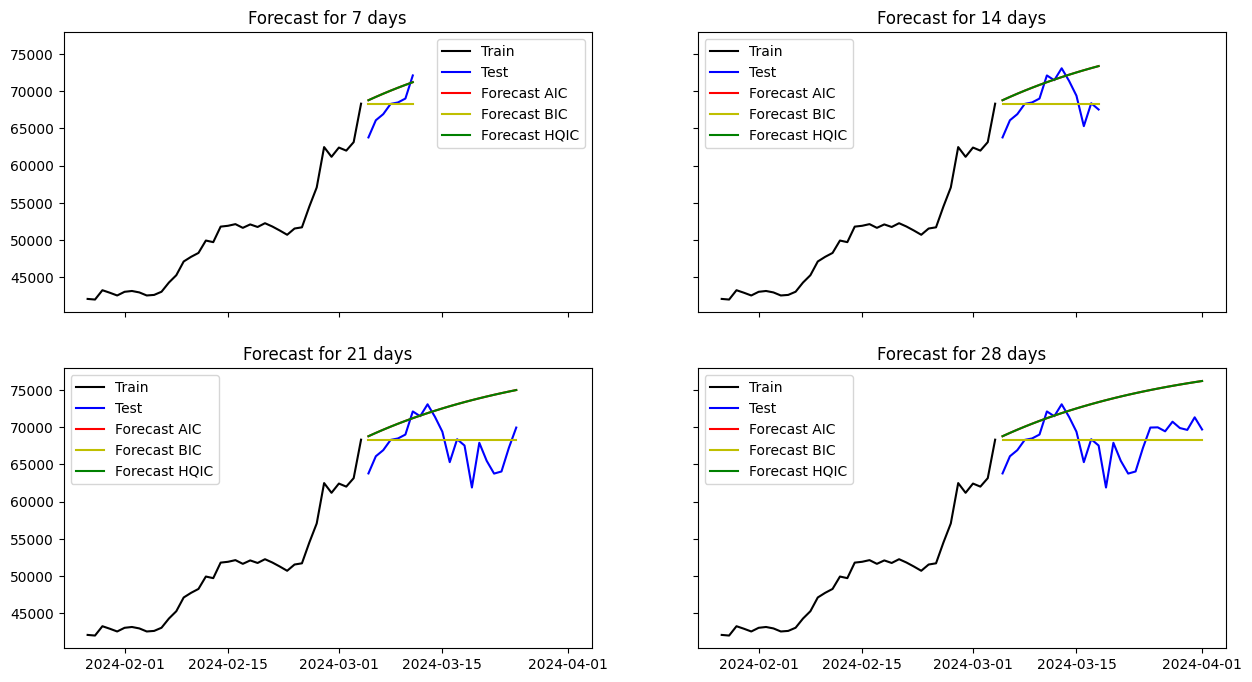

In [52]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)

results_rf = pd.DataFrame(columns=["", "MAPE", "MAE", "RMSE", "MSE", "R2"])

predictions = {"predictions_aic": {f"{n}d": [] for n in nb_day_predicted}, "predictions_bic": {f"{n}d": [] for n in nb_day_predicted}, "predictions_hqic": {f"{n}d": [] for n in nb_day_predicted}}

arima_aic = ARIMA(train, order=best_order_aic).fit()
arima_bic = ARIMA(train, order=best_order_bic).fit()
arima_hqic = ARIMA(train, order=best_order_hqic).fit()


for i, n_test in enumerate(nb_day_predicted):
    test = btc_df.close[train_size:train_size + n_test]
    dates_test = btc_df.date[train_size:train_size + n_test]
    
    predictions["predictions_aic"][f"{n_test}d"] = arima_aic.forecast(steps=n_test)
    predictions["predictions_bic"][f"{n_test}d"] = arima_bic.forecast(steps=n_test)
    predictions["predictions_hqic"][f"{n_test}d"] = arima_hqic.forecast(steps=n_test)
       
    results_rf.loc[len(results_rf)] = [f"{n_test} (aic)", *forecast_accuracy(test, predictions["predictions_aic"][f"{n_test}d"])]
    results_rf.loc[len(results_rf)] = [f"{n_test} (bic)", *forecast_accuracy(test, predictions["predictions_bic"][f"{n_test}d"])]
    results_rf.loc[len(results_rf)] = [f"{n_test} (hqic)", *forecast_accuracy(test, predictions["predictions_hqic"][f"{n_test}d"])]

    axes[i//2, i%2].plot(dates_train[300:], train[300:], label="Train", color='k')
    axes[i//2, i%2].plot(dates_test, test, label="Test", color='b')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_aic"][f"{n_test}d"], label="Forecast AIC", color='r')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_bic"][f"{n_test}d"], label="Forecast BIC", color='y')
    axes[i//2, i%2].plot(dates_test, predictions["predictions_hqic"][f"{n_test}d"], label="Forecast HQIC", color='g')
    axes[i//2, i%2].set_title(f"Forecast for {n_test} days")
    axes[i//2, i%2].legend()
plt.show()

In [53]:
print(results_rf.to_string(index=False))

           MAPE  MAE     RMSE  MSE     R2
  7 (aic) 0.037 2481  7651490 2766 -0.321
  7 (bic) 0.027 1834  6046739 2459 -0.044
 7 (hqic) 0.037 2481  7651490 2766 -0.321
 14 (aic) 0.043 2902 12711960 3565 -0.904
 14 (bic)  0.03 2052  6793389 2606 -0.017
14 (hqic) 0.043 2902 12711960 3565 -0.904
 21 (aic) 0.073 4793 34802770 5899 -3.082
 21 (bic) 0.036 2378  8919804 2986 -0.046
21 (hqic) 0.073 4793 34802770 5899 -3.082
 28 (aic) 0.075 4997 34072721 5837 -3.496
 28 (bic) 0.033 2228  7579626 2753   -0.0
28 (hqic) 0.075 4997 34072721 5837 -3.496


Without rolling forecast, the model doesn't manage to predict the bitcoin price as we can see with the graphics. Consequently we won't do the analysis of the residuals.